# 系列四：纯因子组合构建
---

参考文献：
> 财通金工——Barra 模型深化：纯因子组合构建

In [12]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append("C:\\Users\\yyhan\\Desktop\\自定义包\\FactorAnalysis\\")
from FactorAnalysis import *
from empyrical import cum_returns, annual_return, annual_volatility, sharpe_ratio
%matplotlib inline

In [2]:
# 导入数据并整合
data_path = os.path.join(os.path.dirname(os.getcwd()), "data")
factor_names = [x for x in os.listdir(data_path) if "." not in x]  # 所有大类因子名
factor_names.remove("industry")

def comp(fac_name):
    """
    输入大类因子名，返回等权合成后的因子暴露

    Parameters
    ----------
    fac_name: str
        大类因子名.
    
    Returns
    -------
    等权合成后的因子暴露：dict of pd.Series
    """
    factor_path = os.path.join(data_path, fac_name)
    factor = read_data(factor_path, **{"index_col": 0})
    Compeq(factor, list(range(len(list(factor.values())[0].columns))), name=fac_name)

    return dict(zip(factor.keys(), [x.iloc[:, -1] for x in factor.values()]))

comp_factor = dict(zip(factor_names, [comp(x) for x in factor_names]))  # 合成后的所有因子

In [3]:
all_months = list(comp_factor.values())[0]  # 所有月份
def merge_factor():
    """
    将各因子合并到一个表格
    """
    result = {}
    for mon in all_months:
        result[mon] = pd.concat(
            [comp_factor[name][mon] for name in factor_names],
            axis=1,
            join="inner",
        )

    return result

style_factor = merge_factor()

In [4]:
# 行业因子与风格因子合并并加入收益率、市值
industry_factor = read_data(
    os.path.join(data_path, "industry"),
    **{"index_col": 0, "encoding": "gbk"}
)
factors = add_data(industry_factor, style_factor)
r_t1 = pd.read_csv(os.path.join(data_path, "r_t+1.csv"), index_col=0)
cap = pd.read_csv(os.path.join(data_path, "MktCap.csv"), index_col=0)
all_data = add_data(factors, r_t1, "r_t+1")
all_data = add_data(all_data, cap, "cap")

In [5]:
# 风格因子去缺失值、去极值、标准化处理
def PreRaw():
    result = {}
    for mon in all_months:
        temp = all_data[mon].copy()
        temp = temp.dropna()
        temp.iloc[:, 29:36] = temp.iloc[:, 29:36].apply(lambda x: OutProcess(x, method="AM"))
        temp.iloc[:, 29:36] = temp.iloc[:, 29:36].apply(lambda x: Standardization(
            x, 
            method="CWM",
            cap=temp.iloc[:, 37]
        ))
        result[mon] = temp

    return result

all_data_pro = PreRaw()

# 1 纯因子组合收益
-----
模型：
$$USE3:r_{n}=\sum_{i}X_{ni}f_{i}+\sum_{s}X_{ns}f_{s}+\varepsilon _{n}$$
$$USE4:r_{n}=f_{c}+\sum_{i}X_{ni}f_{i}+\sum_{s}X_{ns}f_{s}+\varepsilon _{n}$$

模型采用WLS回归得到的因子收益即为纯因子组合收益。  
下面进行求解（根据USE4）：

In [6]:
industry_names = list(list(all_data_pro.values())[0].columns[:29])

In [28]:
# WLS求解因子收益
def WLS():
    """
    WLS求解纯因子收益

    Returns
    -------
    因子收益：pd.DataFrame
        index为日期.
    因子收益t值：pd.DataFrame
        index为日期.
    R方：pd.Series
        每期截面回归的R方.
    """
    fret, tvalues = [], []
    R2 = pd.Series([np.nan] * len(all_months), index=all_months)
    for mon in all_months:
        temp = all_data_pro[mon].copy()
        model = sm.WLS(
            temp.iloc[:, 36].values,
            sm.add_constant(temp.iloc[:, :36].values),
            weights=temp.iloc[:, -1].values
        ).fit()  # 拟合
        fret.append(model.params)
        tvalues.append(model.tvalues)
        R2.loc[mon] = model.rsquared
    
    fret = pd.DataFrame(fret, index=all_months, columns=["国家因子"] + industry_names + factor_names)
    tvalues = pd.DataFrame(tvalues, index=all_months, columns=["国家因子"] + industry_names + factor_names)

    return fret, tvalues, R2

fret1, tvalues1, WLSR2 = WLS()

In [29]:
# 保存结果
with pd.ExcelWriter("result.xlsx") as writer:
    fret1.to_excel(writer, "纯因子收益（WLS）")
    tvalues1.to_excel(writer, "WLS t")

In [7]:
with pd.ExcelFile("result.xlsx") as reader:
    fret1 = pd.read_excel(reader, "纯因子收益（WLS）", index_col=0)
    tvalues1 = pd.read_excel(reader, "WLS t", index_col=0)

In [31]:
# 计算股票利用率
def stock_use_ratio():
    ratio = pd.Series([np.nan] * len(all_months), index=all_months)
    for mon in all_months:
        ratio.loc[mon] = len(all_data_pro[mon]) / len(all_data[mon])

    return ratio

stock_ratio = stock_use_ratio()

In [32]:
pd.concat([WLSR2, stock_ratio], axis=1, keys=["Rsquare", "股票利用率"]).to_clipboard()

风格因子的纯因子组合净值走势如下：

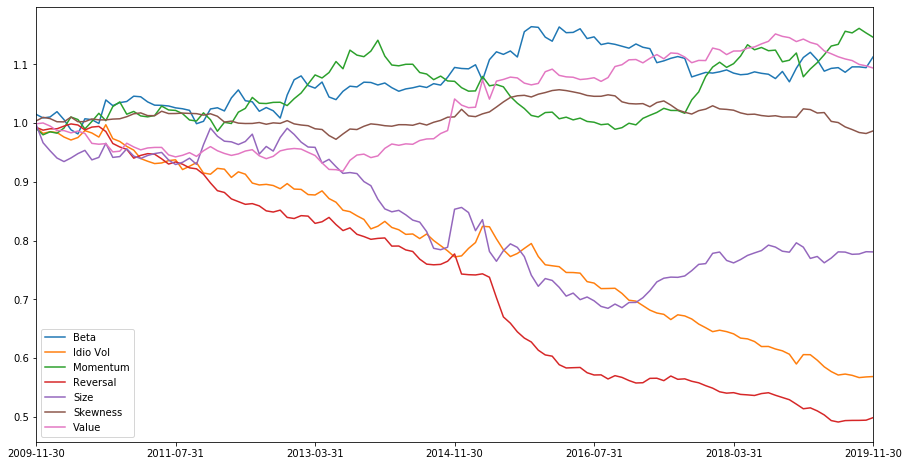

In [34]:
(1 + fret1).cumprod().iloc[:, 30:].plot(figsize=(15, 8))

多因子回归$R^{2}$及股票利用率走势如下：

![图表1.png](https://i.loli.net/2020/08/15/mOn8sixvqr39NdR.png)

我发现这一套因子竟然比业界所使用的一套因子$R^{2}$明显高。

统计纯行业因子显著度（截面回归t值绝对值大于2的占比）和绩效如下：

In [13]:
# 纯行业因子相关统计
def summary1():
    ret = fret1.iloc[:, 1:30]     # 纯行业因子收益
    t = tvalues1.iloc[:, 1:30]    # 纯行业因子t值
    result = []
    result.append(t.apply(lambda x: (x.abs() > 2).sum() / len(x)))          # 因子显著度
    result.append(t.apply(lambda x: (x.abs().mean())))                      # t值绝对值平均
    result.append(ret.apply(lambda x: annual_return(x, period="monthly")))  # 因子年化收益
    result.append(ret.apply(annual_volatility, **{"period": "monthly"}))    # 因子年化波动
    result.append(ret.apply(lambda x: sharpe_ratio(x, period="monthly")))   # 因子收益夏普比率

    result = pd.concat(
        result,
        axis=1,
        keys=[
            "因子显著度", "t值绝对值平均", "因子年化收益",
            "因子年化波动", "因子收益率夏普"
        ]
    )
    result.iloc[:, [0, 2, 3, 4]] = result.iloc[:, [0, 2, 3, 4]].applymap(lambda x: "%.2f%%" % (x * 100))

    return result

summary1()

,因子显著度,t值绝对值平均,因子年化收益,因子年化波动,因子收益率夏普
(中信)汽车,60.33%,3.058965,-0.75%,10.61%,-1.79%
(中信)煤炭,72.73%,3.993198,-9.79%,16.69%,-53.42%
(中信)食品饮料,70.25%,4.874273,10.72%,15.38%,74.06%
(中信)轻工制造,13.22%,0.985675,0.43%,6.74%,9.71%
(中信)餐饮旅游,24.79%,1.446604,0.84%,12.57%,12.87%
(中信)医药,63.64%,3.976470,4.08%,12.29%,38.59%
(中信)农林牧渔,47.93%,2.522395,0.73%,12.52%,12.02%
(中信)机械,50.41%,2.483011,-1.08%,9.63%,-6.65%
(中信)钢铁,60.33%,2.972766,-6.20%,14.08%,-38.39%
(中信)基础化工,34.71%,1.773196,-2.74%,6.47%,-39.66%


风格因子绩效相关统计如下：

第t期因子k的自稳定系数定义为：
$$\rho _{kt}=\frac{\sum_{n}w_{n}\left ( X_{nk}^{t}-\bar{X}_{k}^{t} \right )\left ( X_{nk}^{t+1}-\bar{X}_{k}^{t+1} \right )}{\sqrt{\sum_{n}w_{n}\left ( X_{nk}^{t}-\bar{X}_{k}^{t} \right )^{2}}\sqrt{\sum_{n}w_{n}\left ( X_{nk}^{t+1}-\bar{X}_{k}^{t+1} \right )^{2}}}$$
$$其中w_{n}为第t期股票n的市值权重$$